## Main Program for classification

# imports

In [1]:
# imports

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from shapely.geometry import Polygon, box
from shapely.affinity import scale, affine_transform
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# functions for feature exctraction

In [2]:
#function to plot image with given polygons
def plot_picture_with_polygons(image, polygons):
    fig, ax = plt.subplots(1, figsize=(20,12))
    ax.imshow(image)
    for polygon in polygons:
        points = polygon
        polygon = patches.Polygon(points, closed=True, edgecolor='red', fill=False, linewidth=2, label=label)
        ax.add_patch(polygon)
    plt.show()

In [5]:
#function to find rough areas in picture
def rough_image_filter(image, threshold=8):

    #read in image as greyscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #apply local binary pattern
    lbp = local_binary_pattern(image, P=8, R=2, method='uniform')

    lbp_uint8 = np.uint8((lbp / lbp.max())*255)
    
    blurred = cv2.blur(lbp_uint8, (5, 5), 0)
    mean = np.mean(blurred)
    std = np.std(blurred)
    median = np.median(blurred)
    #apply thresholding
    _, binary_image = cv2.threshold(blurred, mean - std, 255, cv2.THRESH_BINARY) 

    binary_blurred = cv2.blur(binary_image, (50, 50), 0)
    mean = np.mean(binary_blurred)
    std = np.std(binary_blurred)
    #apply thresholding
    _, binary_image = cv2.threshold(binary_blurred, mean - 1.5 * std, 255, cv2.THRESH_BINARY) # normlaize and convert to uint8, then blur

    return binary_image

In [9]:
#function to identify reddisch areas in an image
def reddish_image_filter(image):

    def color_detector(image, lower_bounds: list, upper_bounds: list) -> list:
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
        for lower_bound, upper_bound in zip(lower_bounds, upper_bounds):
            lower_bound = np.array(lower_bound)
            upper_bound = np.array(upper_bound)
            mask += cv2.inRange(hsv_image, lower_bound, upper_bound)
        return mask

    rusty_lower_bounds = [[0, 40, 50]]
    rusty_upper_bounds = [[20, 255, 200]]
    reddish_areas = color_detector(image, rusty_lower_bounds, rusty_upper_bounds)

    return reddish_areas

In [57]:
#Bild einlesen
i = str(500).zfill(4)
image_path = f"data/dacl10k_v2_devphase/images/train/dacl10k_v2_train_{i}.jpg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

#Defekte einlesen
annotations_path = f"data/dacl10k_v2_devphase/annotations/train/dacl10k_v2_train_{i}.json"
with open(annotations_path, 'r') as file:
    annotations = json.load(file)
defects = annotations['shapes']

#Areas finden
#darker_image, darker_polygons = find_darker_areas(image)
reddish_image = reddish_image_filter(image)
rough_image = rough_image_filter(image)


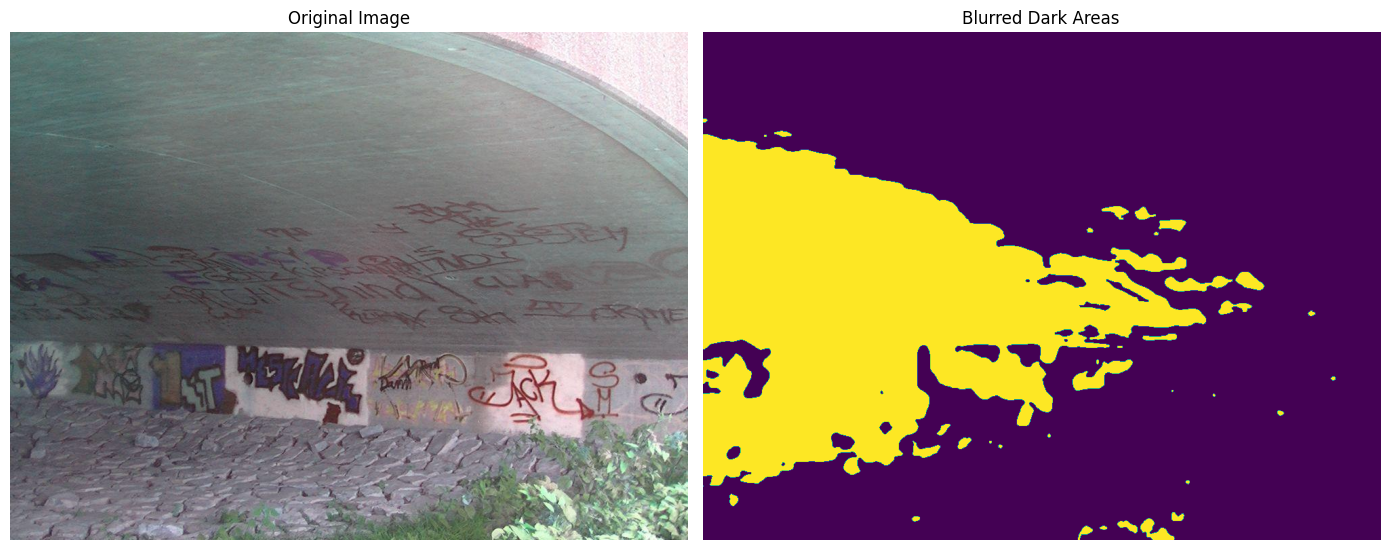

0


In [109]:
i = str(10).zfill(4)
image_path = f"data/dacl10k_v2_devphase/images/train/dacl10k_v2_train_{i}.jpg"
image = cv2.imread(image_path, cv2.IMREAD_COLOR)

#Defekte einlesen
annotations_path = f"data/dacl10k_v2_devphase/annotations/train/dacl10k_v2_train_{i}.json"
with open(annotations_path, 'r') as file:
    annotations = json.load(file)
defects = annotations['shapes']

#find darker areas in an image
def darker_image_filter(image, z = 200):
    # Convert image to grayscale:
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grey_image = cv2.blur(grey_image, (15, 15), 0)
    mean = np.mean(grey_image)
    std = np.std(grey_image) / 250
    dark_areas = (grey_image < mean - z * std)
    dark_areas = dark_areas.astype(np.uint8)
    blurred = cv2.blur(dark_areas, (5, 5), 0) *255
    return blurred


blurred = darker_image_filter(image, 150)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Display the original image
axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the blurred image
axes[1].imshow(blurred)
axes[1].set_title('Blurred Dark Areas')
axes[1].axis('off')

plt.tight_layout()
plt.show()
print(blurred[0,0])

# functions to evaluate / visualize

In [12]:
#function to calculate the overlapping percentage of a defect polygon with feature polygons
def calculate_overlapping_percentage(defect_polygon, feature_polygons):
    overlapping_quotient = []
    defect_polygon = Polygon(defect_polygon)
    overlapping_area = 0
    for feature_polygon in feature_polygons:
        if len(feature_polygon) > 3:
            feature_polygon = Polygon(feature_polygon)
            try:
                overlapping_area += defect_polygon.intersection(feature_polygon).area
            except:
                pass
    quotient = overlapping_area / defect_polygon.area
    return round(quotient*100, 4)

In [13]:
def get_overlapping_values(filtered_image, defect_polygon):
    
    # Generate polygon mask:
    mask = np.zeros(filtered_image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [defect_polygon], 255)

    # Get bounding box of the polygon:
    minx, miny, maxx, maxy = Polygon(defect_polygon).bounds

    # Extract overlapping pixel values:
    overlapping_values = []
    for i in range(max(0, int(miny) - 1), min(int(maxy) + 1, filtered_image.shape[0])):
        for j in range(max(0, int(minx) - 1), min(int(maxx) + 1, filtered_image.shape[1])):
            if mask[i][j] == 255:
                overlapping_values.append(filtered_image[i][j])

    return overlapping_values

def get_relative_frequencies(values: list) -> dict:
    counts = Counter(values)
    total_count = len(values)
    relative_frequencies = {element: count / total_count for element, count in counts.items()}
    return relative_frequencies

In [14]:
def extract_reddish_feature(image, defect_polygon):

    overlapping_values = get_overlapping_values(image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    try:
        quotient = relative_frequencies[255]
    except:
        quotient = 0
    return quotient

In [15]:
def extract_rough_feature(image, defect_polygon):

    overlapping_values = get_overlapping_values(image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    try:
        quotient = relative_frequencies[0]
    except:
        quotient = 0
    return quotient

In [99]:
def extract_dark_feature(image, defect_polygon):

    overlapping_values = get_overlapping_values(image, defect_polygon)
    relative_frequencies = get_relative_frequencies(overlapping_values)
    try:
        quotient = relative_frequencies[255]
    except:
        quotient = 0
    return quotient

# main

In [100]:
n_pictures = 8
samples = []

for i in range(n_pictures):
    i = str(i).zfill(4)
    if int(i) % 1 == 0:
        print(f"Processing image {i}")

    #Bild einlesen
    image_path = f"data/dacl10k_v2_devphase/images/train/dacl10k_v2_train_{i}.jpg"
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    #Defekte einlesen
    annotations_path = f"data/dacl10k_v2_devphase/annotations/train/dacl10k_v2_train_{i}.json"
    with open(annotations_path, 'r') as file:
        annotations = json.load(file)
    defects = annotations['shapes']

    #Areas finden
    darker_image = darker_image_filter(image)
    reddish_image = reddish_image_filter(image)
    rough_image = rough_image_filter(image)

    for k in range(len(defects)):
        label = defects[k]['label']
        if label in ["Rust", "Graffiti", "Drainage", "Wetspot", "ExposedRebars", "Crack"]:
            #plot_picture_with_polygons(image, rough_polygons)
            defect_polygon = np.array(defects[k]['points'], dtype = np.int32)
            darker_quotient = extract_dark_feature(darker_image, defect_polygon)
            reddish_quotient = extract_reddish_feature(reddish_image, defect_polygon)
            rough_quotient = extract_rough_feature(rough_image, defect_polygon)
            temp_dict = {'label': label, 'darker': darker_quotient, 'reddish': reddish_quotient, 'rough': rough_quotient}
            samples.append(temp_dict)

samples = pd.DataFrame(samples)

Processing image 0000
Processing image 0001
Processing image 0002
Processing image 0003
Processing image 0004
Processing image 0005
Processing image 0006
Processing image 0007


In [101]:
graffiti = samples[samples['label'] == 'Graffiti']
rust = samples[samples['label'] == 'Rust']
drainage = samples[samples['label'] == 'Drainage']
wetspot = samples[samples['label'] == 'Wetspot']
exposedrebars = samples[samples['label'] == 'ExposedRebars']
crack = samples[samples['label'] == 'Crack']

print("Grafitti:")
print(graffiti.loc[:,["darker", "reddish", "rough"]].mean(axis = 0))
print()

print("Rust:")
print(rust.loc[:,["darker", "reddish", "rough"]].mean(axis = 0))
print()

print("Drainage:")
print(drainage.loc[:,["darker", "reddish", "rough"]].mean(axis = 0))
print()

print("Wetspot:")
print(wetspot.loc[:,["darker", "reddish", "rough"]].mean(axis = 0))
print()

print("ExposedRebars:")
print(exposedrebars.loc[:,["darker", "reddish", "rough"]].mean(axis = 0))
print()

print("Crack:")
print(crack.loc[:,["darker", "reddish", "rough"]].mean(axis = 0))

#samples.to_csv('samples.csv', index=False)


Grafitti:
darker     0.191554
reddish    0.056344
rough      0.149545
dtype: float64

Rust:
darker     0.500000
reddish    0.515743
rough      0.000000
dtype: float64

Drainage:
darker     0.939852
reddish    0.000240
rough      0.041218
dtype: float64

Wetspot:
darker     0.863688
reddish    0.049964
rough      0.029670
dtype: float64

ExposedRebars:
darker    NaN
reddish   NaN
rough     NaN
dtype: float64

Crack:
darker     0.126727
reddish    0.011545
rough      0.175934
dtype: float64


In [102]:
#to do

#rewrite darker areas feature extraction method
#write feature extractor to detect lenghty shape of cracks



## Create datasets and classifier

In [103]:
def create_train_test_data(samples, target_label, features):

    # Create rust labels:
    target_class_df = samples.copy()
    target_class_df["target_label"] = target_class_df["label"].apply(lambda x: 1 if x == target_label else 0)

    # Apply train test split:
    x = target_class_df.loc[:, features]
    y = target_class_df.loc[:, "target_label"]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    return x_train, x_test, y_train, y_test


def run_classifier(samples, target_label, features):

    # Generate train test dataset: 
    x_train, x_test, y_train, y_test = create_train_test_data(samples, target_label, features)

    # Initialize the random forest classifier: 
    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Train the classifier:
    clf.fit(x_train, y_train)

    # Test the classifier: 
    y_pred = clf.predict(x_test)

    # Evaluate the classification:
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f'Accuracy: {accuracy}')
    print(f'Classification Report:\n{report}')



## Apply classification for different defect classes

**Rust classification**

In [104]:
# Run classifier for rust: 
run_classifier(samples, "Rust", ["reddish", "rough", "darker"])

Accuracy: 0.7777777777777778
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.00      0.00      0.00         1

    accuracy                           0.78         9
   macro avg       0.44      0.44      0.44         9
weighted avg       0.78      0.78      0.78         9



**Wetspot classification**

In [105]:
# Rund classifier for wetspots:
run_classifier(samples, "Wetspot", ["rough", "darker"])


Accuracy: 0.8888888888888888
Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       0.00      0.00      0.00         1

    accuracy                           0.89         9
   macro avg       0.44      0.50      0.47         9
weighted avg       0.79      0.89      0.84         9



c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

**Graffiti classification**

In [106]:
# Run classifier for Graffiti:
run_classifier(samples, "Graffiti", ["reddish", "rough", "darker"])

Accuracy: 0.7777777777777778
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.80      0.80      0.80         5

    accuracy                           0.78         9
   macro avg       0.78      0.78      0.78         9
weighted avg       0.78      0.78      0.78         9

